# Radiative cooling glass coating

Air conditioning accounts for about 10% of global electricity use, and demand is projected to rise significantly. New approaches like radiative cooling can reduce this energy demand and associated greenhouse gas emissions. Radiative cooling uses materials applied to buildings that reflect sunlight while emitting heat through the atmospheric transparency window (8-13 μm) to outer space (~3K). This can passively cool buildings below ambient temperature. An ideal radiative cooling material would combine high solar reflection and selective infrared emission for cooling, easy manufacturability at scale, mechanical robustness, and long-term stability under outdoor environmental exposure. A recent paper introduces a new stable, scalable, and low-cost radiative cooling coating using a microporous glass-Al$_2$O$_3$ particle composite to address these needs.

This notebook simulates the emissivity of the 100 μm thick coating and the result shows that the emissivity (absorptance) of the coating is near unity in the atmospheric transparency window. The design is based on `Xinpeng Zhao et al., A solution-processed radiative cooling glass. Science 382, 684-691(2023).`[DOI: 10.1126/science.adi2224](https://www.science.org/doi/10.1126/science.adi2224).

This notebook is contributed by Dr. Yurui Qu.

<img src="img/radiative_cooling_glass.png" width="500" alt="Schematic of the radiative cooling glass coating">

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.dispersion import FastDispersionFitter, AdvancedFastFitterParam

## Simulation Setup

The 100 μm thick coating consists of randomly placed Al$_2$O$_3$ spheres with 250 nm radius and SiO$_2$ spheres with 4 μm radius. The Al$_2$O$_3$ spheres and the and SiO$_2$ spheres take up 20% and 30% of the total volume of the coating layer, respectively. We truncate the coating to 20 μm in the in-plane directions and will apply the periodic boundary condition.

In [2]:
# Define Paramters
# radius and location of the sphere
radius_Al2O3 = 0.25
radius_SiO2 = 4 # exp is 6um
box_size_xy = 20
box_size_z = 100

vol_Al2O3 = 4/3 * np.pi * np.power(radius_Al2O3,3)
vol_SiO2 = 4/3 * np.pi * np.power(radius_SiO2,3)
vol_box = box_size_xy * box_size_xy * box_size_z
num_Al2O3 = int(np.floor(0.2 * vol_box / vol_Al2O3))   # 20% of volumn is Al2O3
num_SiO2 = int(np.floor(0.3 * vol_box / vol_SiO2))   # 30% of volumn is SiO2
print('num_Al2O3:',num_Al2O3)
print('num_SiO2:',num_SiO2)

num_Al2O3: 122230
num_SiO2: 44


The refractive indices of Al$_2$O$_3$ and SiO$_2$ will be read from .csv files and fit with Tidy3D's [FastDispersionFitter](../_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html). Due to the phonon resonances in the mid-infrared, both materials require a relatively large number of poles to yield a good fit. 

Output()

[11:43:54] WARNING: Unable to fit with weighted RMS error under  ]8;id=243488;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\plugins\dispersion\fit_fast.py\fit_fast.py]8;;\:]8;id=88872;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\plugins\dispersion\fit_fast.py#843\843]8;;\
           'tolerance_rms' of 0.02                                              

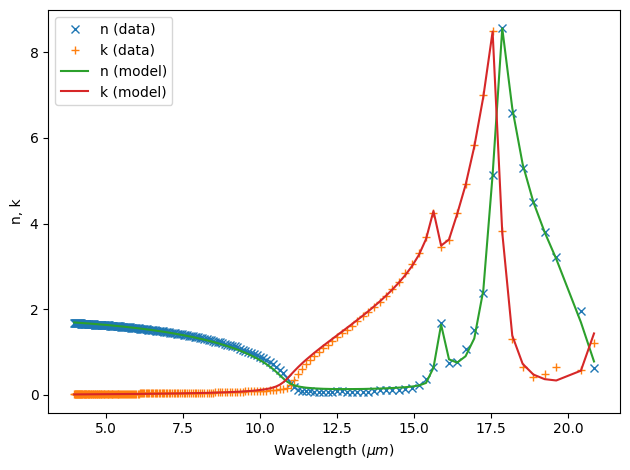

In [3]:
# permittivity of Al2O3 
mat_Al2O3 = "misc/mat_Al2O3.csv"

advanced_param = AdvancedFastFitterParam(weights=(1,1))
fitter = FastDispersionFitter.from_file(mat_Al2O3, skiprows=1, delimiter=",")
medium_Al2O3, rms_error = fitter.fit(max_num_poles=6, advanced_param=advanced_param, tolerance_rms=2e-2)
fitter.plot(medium_Al2O3)
plt.show()

Output()

[11:44:01] WARNING: Unable to fit with weighted RMS error under  ]8;id=951449;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\plugins\dispersion\fit_fast.py\fit_fast.py]8;;\:]8;id=563283;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\plugins\dispersion\fit_fast.py#843\843]8;;\
           'tolerance_rms' of 0.02                                              

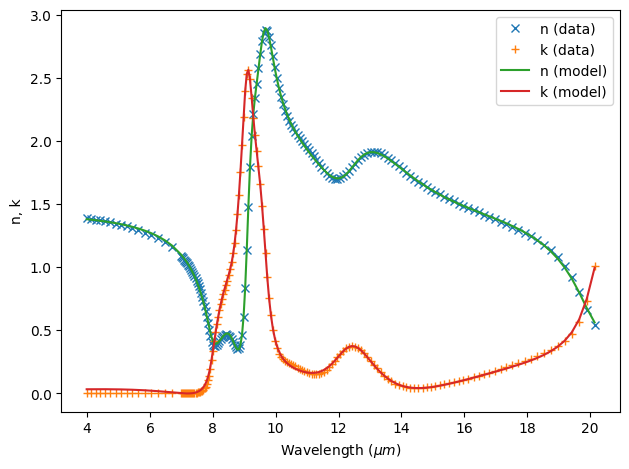

In [4]:
mat_SiO2 = "misc/mat_SiO2.csv"

fitter = FastDispersionFitter.from_file(mat_SiO2, skiprows=1, delimiter=",")
medium_SiO2, rms_error = fitter.fit(max_num_poles=8, advanced_param=advanced_param, tolerance_rms=2e-2)
fitter.plot(medium_SiO2)
plt.show()

Define some basic simulation parameters.

In [5]:
# free space central wavelength
wl_start = 4  # wavelength
wl_end = 20  # wavelength
freq_start = td.C_0 / wl_end
freq_end = td.C_0 / wl_start

freqs = np.linspace(freq_start, freq_end, 100)  # freqeucny range of the simulation
freq0 = (freq_start + freq_end)/2  # central frequency
freqw = freq_end - freq_start  # width of the frequency range

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 2 * wl_end
buffer_source = 1 * wl_end

# set the domain size in x, y, and z
domain_size_xy = box_size_xy 
domain_size_z = buffer_PML + box_size_z + buffer_PML

# construct simulation size array
sim_size = (domain_size_xy, domain_size_xy, domain_size_z)

Next, we generate the randomly placed spheres.

In [6]:
# Create random structures
SiO2_geometry = []
Al2O3_geometry = []
geometry = []
for i in range(num_SiO2):
    position_xy = (box_size_xy - 2*radius_SiO2) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_SiO2) * (np.random.rand(1) - 0.5) 
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Sphere(center=position, radius=radius_SiO2)
    SiO2_geometry.append(sphere)
    
geometry.append(td.Structure(geometry=td.GeometryGroup(geometries=SiO2_geometry), medium=medium_SiO2))
   
for i in range(num_Al2O3):
    position_xy = (box_size_xy - 2*radius_Al2O3) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_Al2O3) * (np.random.rand(1) - 0.5)
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Sphere(center=position, radius=radius_Al2O3)
    Al2O3_geometry.append(sphere)

geometry.append(td.Structure(geometry=td.GeometryGroup(geometries=Al2O3_geometry), medium=medium_Al2O3))
geometry = tuple(geometry)


A PlaneWave is defined above the coating layer and two [FluxMonitors](../_autosummary/tidy3d.FluxMonitor.html) are defined on both sides of the coating layer to measure transmission and reflection. Lastly, a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) is defined to help visualize the field distribution within the coating layer.

In [7]:
# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, box_size_z/2 + buffer_source),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -box_size_z/2 - (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(
    center=[0, 0, box_size_z/2 + (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[freq0], name="field"
)

[11:44:09] WARNING: Default value for the field monitor           ]8;id=795884;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\components\monitor.py\monitor.py]8;;\:]8;id=24602;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\components\monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

Define a Tidy3D [Simulation](../_autosummary/tidy3d.Simulation.html). 

In [8]:
run_time = 2e-11  # simulation run time

# set up simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.uniform(dl=wl_start/20),
    structures=geometry,
    sources=[plane_wave],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ), 
)  

Before running the simulation, we can inspect a few things to ensure the simulation is set up correctly. First, plot the source time and frequency spectrum.

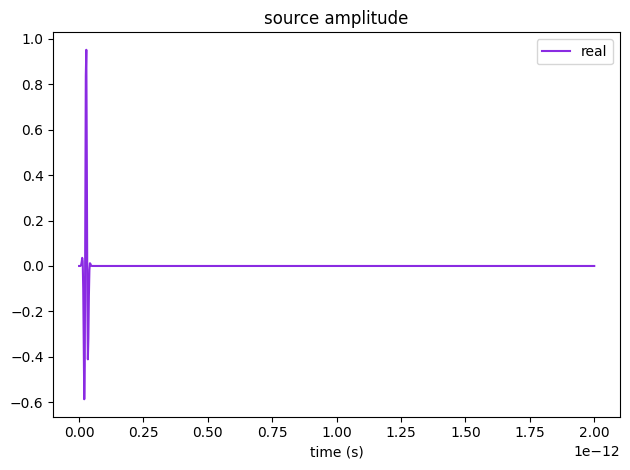

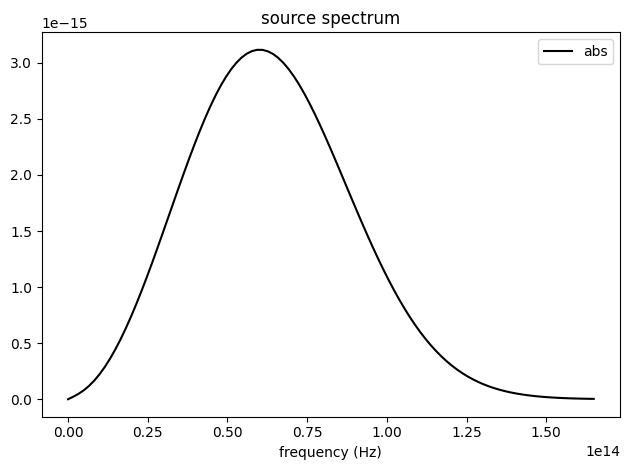

In [9]:
# Visualize source
plane_wave.source_time.plot(np.linspace(0, run_time/10, 1001))
plt.show()

plane_wave.source_time.plot_spectrum(
    times=np.linspace(0, run_time/10, 2000), val="abs"
)
plt.show()

Then, plot the cross sectional view of the simulation. 

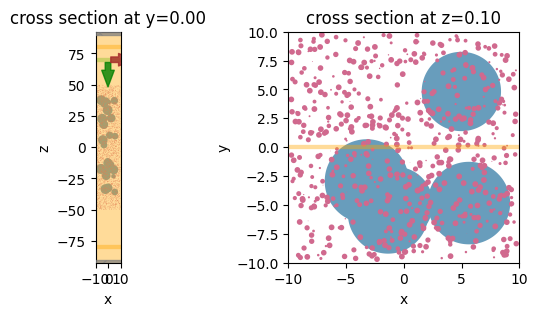

In [10]:
cfig, ax = plt.subplots(1, 2, figsize=(7, 3))
sim.plot(y=0, ax=ax[0])
sim.plot(z=0.1, freq=freq0, ax=ax[1])
plt.show()

## Running the Simulation 

Once we confirm that the simulation is set up correctly, we can upload the simulation and calculate the maximum FlexCredit cost. This step prevents us from submitting large simulations by mistake.

In [11]:
task_id = web.upload(sim, task_name="Simulation")

estimated_cost = web.estimate_cost(task_id)
print(f'The estimated maximum cost is {estimated_cost:.3f} Flex Credits.')

[11:44:30] Created task 'Simulation' with task_id                  ]8;id=879826;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=622267;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-ac012451-a2eb-42a8-9a30-22c8e35abfd4v1'.                       

           View task using web UI at                               ]8;id=382429;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=919602;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=85933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ac012451-a2eb-42a8-9a30-22c8e35abfd4v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=991759;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ac012451-a2eb-42a8-9a30-22c8e35abfd4v1\taskId]8;;\]8;id=85933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ac012451-a2eb-42a8-9a30-22c8e35abfd4v1\=]8;;\]8;id=133018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ac012451-a2eb-42a8-9a30-22c8e35abfd4v1\fdve]8;;\]8;id=85933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ac012451-a2eb-42a8-9a30-22c8e35abfd4v1\-]8;;\              
           ]8;id=85933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ac012451-a2eb-42a8-9a30-22c8e35abfd4v1\ac012451-a2eb-42a8-9a30-22c8e35abfd4v1']8;;\.                             

Output()

The estimated maximum cost is 0.726 Flex Credits.


The cost seems reasonably so we [start](../_autosummary/tidy3d.web.start.html) the task and [monitor](../_autosummary/tidy3d.web.monitor.html) its status. After the simulation is complete, we can print out the real cost.

In [12]:
web.start(task_id)
web.monitor(task_id, verbose=True)

import time
time.sleep(20)
print("Billed flex unit cost: ", web.real_cost(task_id))

sim_data = web.load(task_id, path="data/cooling.hdf5")

# Show the output of the log file
print(sim_data.log)

[11:45:46] status = queued                                         ]8;id=443034;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=252640;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#361\361]8;;\

Output()

[11:46:25] status = preprocess                                     ]8;id=193070;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=451732;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#355\355]8;;\

[11:46:55] Maximum FlexCredit cost: 0.726. Use                     ]8;id=281823;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=323822;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=94247;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=110091;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#377\377]8;;\

           running solver                                          ]8;id=608953;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=482703;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=189737;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=769373;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[11:49:38] early shutoff detected, exiting.                        ]8;id=858367;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=156149;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=750772;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=29255;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#420\420]8;;\

Output()

[11:50:00] status = success                                        ]8;id=78879;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=756906;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#427\427]8;;\

Billed flex unit cost:  0.2613711908533915


Output()

[11:50:23] loading SimulationData from data/cooling.hdf5           ]8;id=852311;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=976564;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_jax\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\

Simulation domain Nx, Ny, Nz: [100, 100, 924]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 9.2600e+06.
Using subpixel averaging: True
Number of time steps: 5.2452e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 3.8131e-16


Compute source modes time (s):     22.3489
Compute monitor modes time (s):    2.3306
Rest of setup time (s):            34.0244

Running solver for 52452 time steps...
- Time step     70 / time 2.67e-14s (  0 % done), field decay: 1.00e+00
- Time step   2098 / time 8.00e-13s (  4 % done), field decay: 4.25e-02
- Time step   4196 / time 1.60e-12s (  8 % done), field decay: 9.84e-04
- Time step   6294 / time 2.40e-12s ( 12 % done), field decay: 1.59e-04
- Time step   8392 / time 3.20e-12s ( 16 % done), field decay: 5.67e-05
- Time step  10490 / time 4.00e-12s ( 20 % done), field decay: 2.71e-05
- Time step  12588 / time 4.80e-12s ( 24 % done), field decay: 1.61e-05
- Time step  14686 / time 5.60e-12s ( 28 % done), field decay: 1.30e-05
- Ti

## Result Visualization 

After the simulation is complete, we will plot the transmission, reflection, and absorption spectra. The result shows that the absorption is nearly 100% in the atmospheric transparency window of 8-13 μm. Furthermore, based on Kirchhoff's law of thermal radiation, the emissivity of a material is equal to its absorptance, we know that the infrared emissivity of the coating layer is close to unity. 

Lastly, we can plot the field distribution within the coating layer. The plot shows that the electromagnetic energy is strongly absorbed as it propagates into the layer. 

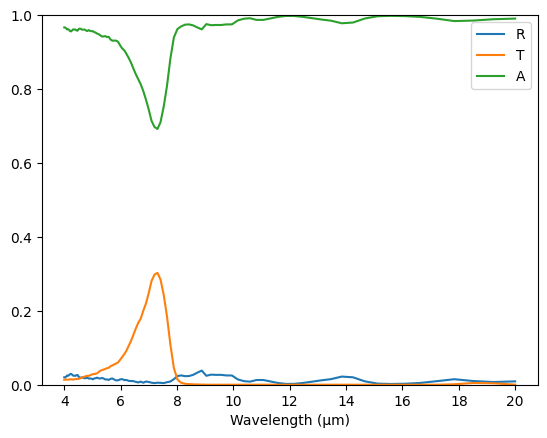

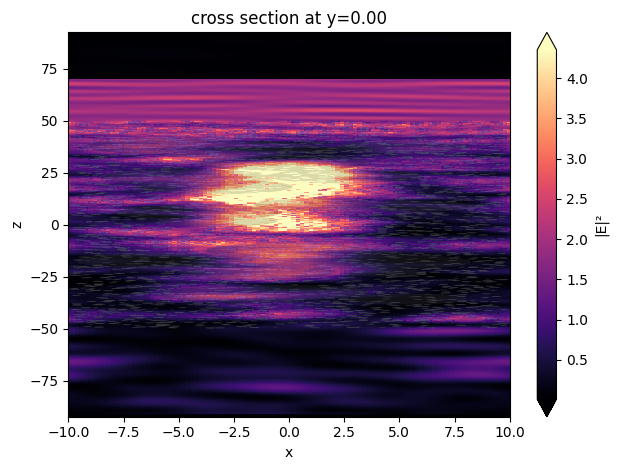

In [13]:
# Result Visualization
R = sim_data["R"].flux
T = -sim_data["T"].flux
A = 1 - R - T
plt.plot(td.C_0 /freqs, R, td.C_0 /freqs, T, td.C_0 /freqs, A)

# Save the absorption spectrum as as a .txt file
np.savetxt('data/Abs_4-20um.txt', (np.transpose((td.C_0 /freqs, A))))

plt.xlabel("Wavelength (μm)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()

ax = sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
ax.set_aspect('auto')
plt.show()